Spark Session

In [60]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Instacart Aisle FP-Growth").getOrCreate()

#The Data Basics

In [61]:
df = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)
df.show(5)

+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|        product_name|aisle_id|department_id|               aisle|department|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+--------------------+--------+-------------+--------------------+----------+-------+--------+------------+---------+-----------------+----------------------+
|  593759|     11068|                4|        1|Medium Cheddar Ch...|      21|           16|     packaged cheese|dairy eggs|  51780|   prior|          68|        4|               12|                   7.0|
| 1214222|     10749|                8|        1|Organic Red Bell ...|      83|            4|    fresh vegetables|   produce| 200087|   prior|          10|        4|       

In [62]:
df.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: integer (nullable = true)
 |-- department_id: integer (nullable = true)
 |-- aisle: string (nullable = true)
 |-- department: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)



In [63]:
#Create a new dataset thats only Order Id and Aisle
aisle_df = df.select("order_id", "aisle").dropna()
aisle_df.show(5, truncate=False)

+--------+--------------------------+
|order_id|aisle                     |
+--------+--------------------------+
|593759  |packaged cheese           |
|1214222 |fresh vegetables          |
|3064778 |chips pretzels            |
|2785011 |soy lactosefree           |
|1002723 |plates bowls cups flatware|
+--------+--------------------------+
only showing top 5 rows



In [64]:
#Group by Order Id
from pyspark.sql.functions import collect_set
aisle_baskets_df = aisle_df.groupBy("order_id").agg(collect_set("aisle").alias("items"))

aisle_baskets_df.show(5, truncate=False)

+--------+-------------------------------+
|order_id|items                          |
+--------+-------------------------------+
|1       |[fresh vegetables]             |
|5       |[body lotions soap]            |
|31      |[packaged vegetables fruits]   |
|40      |[water seltzer sparkling water]|
|43      |[trash bags liners]            |
+--------+-------------------------------+
only showing top 5 rows



# Initial Analysis: Reorder-Based Association Rules (FP_Growth)

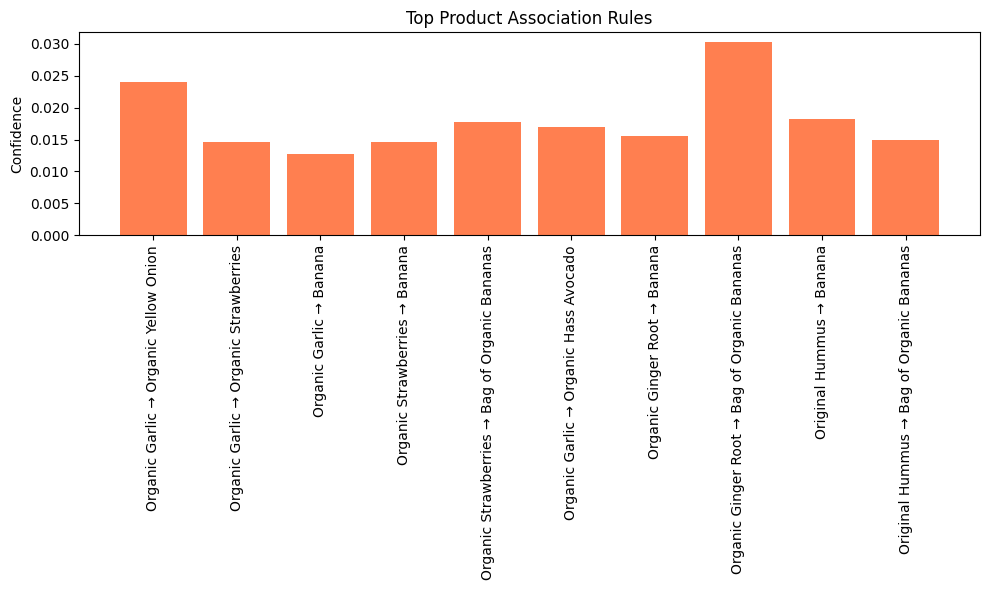

In [65]:
import pandas as pd
import matplotlib.pyplot as plt

# Simulated top product-level rules from multi_baskets_df (based on Spark output you shared)
data = {
    'antecedent': ['Organic Garlic', 'Organic Garlic', 'Organic Garlic', 'Organic Strawberries', 'Organic Strawberries',
                   'Organic Garlic', 'Organic Ginger Root', 'Organic Ginger Root', 'Original Hummus', 'Original Hummus'],
    'consequent': ['Organic Yellow Onion', 'Organic Strawberries', 'Banana', 'Banana', 'Bag of Organic Bananas',
                   'Organic Hass Avocado', 'Banana', 'Bag of Organic Bananas', 'Banana', 'Bag of Organic Bananas'],
    'confidence': [0.024, 0.0146, 0.0128, 0.0146, 0.0177, 0.0169, 0.0156, 0.0303, 0.0183, 0.0149]
}

df = pd.DataFrame(data)

# Create labels
labels = [f"{a} → {c}" for a, c in zip(df['antecedent'], df['consequent'])]

# Plot vertical bar chart
plt.figure(figsize=(10, 6))
plt.bar(labels, df['confidence'], color='coral')
plt.xticks(rotation=90)
plt.ylabel("Confidence")
plt.title("Top Product Association Rules")
plt.tight_layout()
plt.show()


In [66]:
from pyspark.sql.functions import col
df3 = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)
short_cycle_orders = df3.filter(col("days_since_prior_order") <= 10)
long_cycle_orders = df3.filter(col("days_since_prior_order") >= 25)

In [67]:
from pyspark.sql.functions import collect_set
from pyspark.ml.fpm import FPGrowth

# Prepare product baskets
short_product_baskets = (short_cycle_orders
                         .groupBy("order_id")
                         .agg(collect_set("product_name").alias("items")))

long_product_baskets = (long_cycle_orders
                        .groupBy("order_id")
                        .agg(collect_set("product_name").alias("items")))

from pyspark.ml.fpm import FPGrowth

fp_short = FPGrowth(itemsCol="items", minSupport=0.00002, minConfidence=0.05)
model_short = fp_short.fit(short_product_baskets)

fp_long = FPGrowth(itemsCol="items", minSupport=0.00002, minConfidence=0.05)
model_long = fp_long.fit(long_product_baskets)

# Extract rules again
short_rules_df = model_short.associationRules.orderBy("confidence", ascending=False).limit(50).toPandas()
long_rules_df = model_long.associationRules.orderBy("confidence", ascending=False).limit(50).toPandas()


In [68]:
print(short_rules_df.shape)
print(short_rules_df.head())


(2, 5)
                                   antecedent  \
0  [Nonfat Icelandic Style Strawberry Yogurt]   
1                     [Organic Yellow Squash]   

                                        consequent  confidence       lift  \
0  [Icelandic Style Skyr Blueberry Non-fat Yogurt]    0.063559  65.759165   
1                               [Organic Zucchini]    0.050881   9.525129   

    support  
0  0.000032  
1  0.000028  


In [69]:
short_cycle_orders = df3.filter((col("days_since_prior_order") >= 7) & (col("days_since_prior_order") <= 10))
long_cycle_orders = df3.filter((col("days_since_prior_order") >= 25) & (col("days_since_prior_order") <= 30))


In [70]:
from pyspark.sql.functions import count

# Most frequently ordered products by short-cycle users
top_short_products = (short_cycle_orders
                      .groupBy("product_name")
                      .agg(count("*").alias("count"))
                      .orderBy(col("count").desc())
                      .limit(15)
                      .toPandas())

# Same for long-cycle users
top_long_products = (long_cycle_orders
                     .groupBy("product_name")
                     .agg(count("*").alias("count"))
                     .orderBy(col("count").desc())
                     .limit(15)
                     .toPandas())



<ipython-input-71-e88e46595b60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="product_name", data=df, palette="viridis")


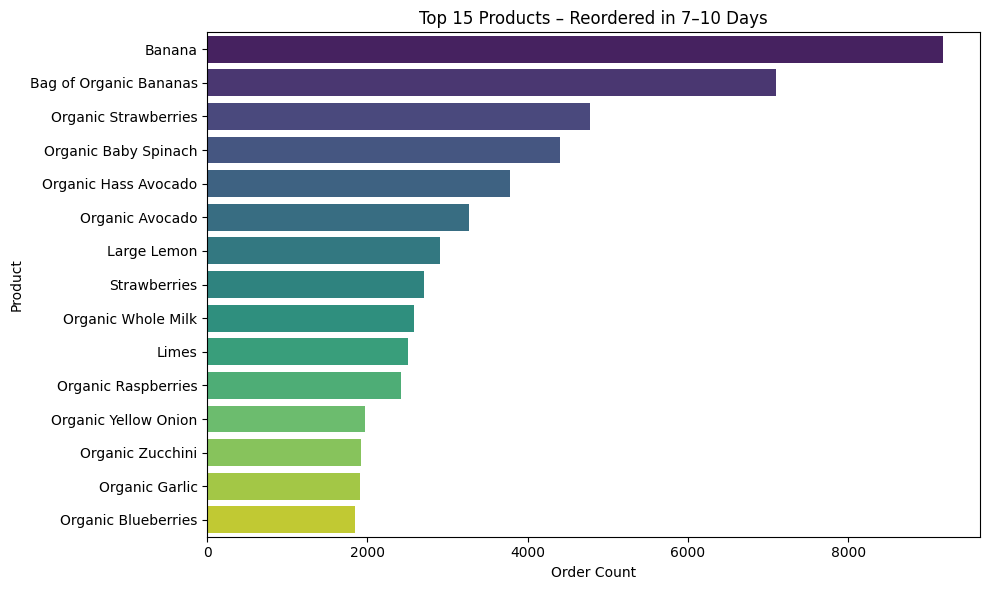

<ipython-input-71-e88e46595b60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="count", y="product_name", data=df, palette="viridis")


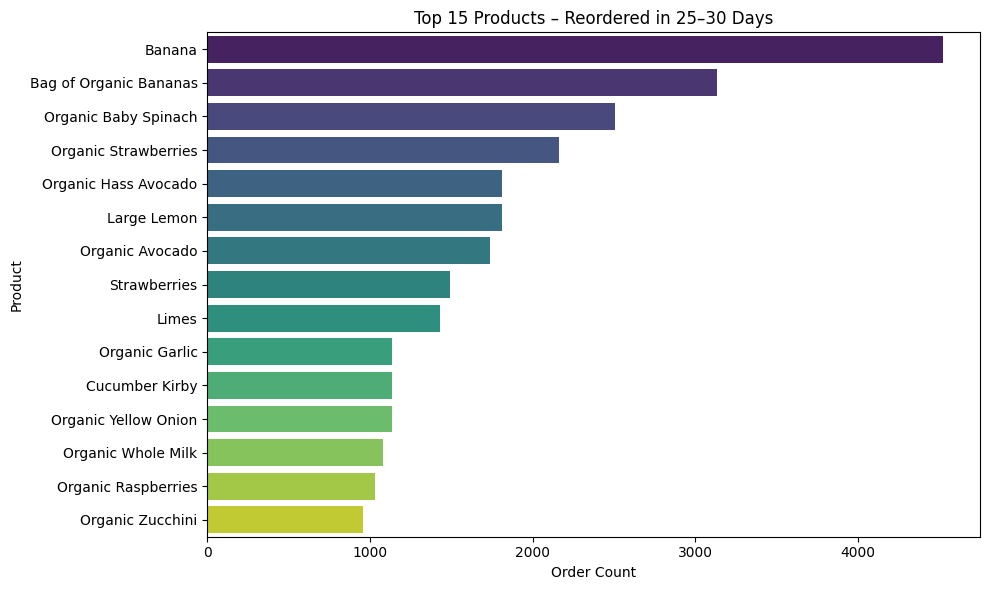

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_products(df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x="count", y="product_name", data=df, palette="viridis")
    plt.title(title)
    plt.xlabel("Order Count")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

plot_top_products(top_short_products, "Top 15 Products – Reordered in 7–10 Days")
plot_top_products(top_long_products, "Top 15 Products – Reordered in 25–30 Days")


# Product-Based Association Rules (FP-Growth)

In [72]:
from pyspark.sql.functions import collect_set
df2 = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)
baskets_df = df2.groupBy("order_id").agg(collect_set("product_name").alias("items"))
baskets_df.show(5, truncate=False)


+--------+-----------------------------------------+
|order_id|items                                    |
+--------+-----------------------------------------+
|1       |[Organic Celery Hearts]                  |
|5       |[French Lavender Hand Wash]              |
|31      |[Organic Baby Spinach]                   |
|40      |[Sparkling Natural Mineral Water]        |
|43      |[13 Gallon Kitchen Drawstring Trash Bags]|
+--------+-----------------------------------------+
only showing top 5 rows



In [73]:
from pyspark.sql.functions import size

multi_baskets_df = baskets_df.filter(size("items") > 1)
print("Multi-item baskets:", multi_baskets_df.count())

Multi-item baskets: 600896


In [74]:
from pyspark.ml.fpm import FPGrowth

# Ensure items are arrays (e.g., already tokenized/split list)
# Example: [["bread", "milk"], ["bread", "diaper", "beer", "egg"], ...]
fp_df = baskets_df.select('items')

# Apply Spark FPGrowth
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.00005, minConfidence=0.01)
model = fpGrowth.fit(baskets_df)

# Frequent itemsets
freq_items = model.freqItemsets
freq_items.show()

# Association rules
rules = model.associationRules
rules.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Freeze Dried Ins...| 113|
|[Velveeta Shells ...| 145|
|[Chocolate Chip C...| 142|
|[Gluten Free Brow...| 111|
|[Fresh Cut Green ...| 126|
|[Organic Flax Plu...| 189|
|[Organic Minestro...|  80|
|[Lightly Salted A...|  87|
|[Sorbet Pops Stra...| 219|
|[Smoked Pulled Pork]|  86|
|[Brioche Hamburge...|  96|
|[Red Seedless Gra...| 691|
| [Fresh Ginger Root]|1885|
| [Honey Wheat Bread]| 484|
|[Organic Saltine ...|  94|
|[Organic Broccoli...|1393|
|  [Thai Green Curry]| 114|
|[Organic Red Grapes]| 673|
|[Egg & Green Chil...| 103|
|[Wonderful 100% P...| 252|
+--------------------+----+
only showing top 20 rows

+--------------------+--------------------+--------------------+------------------+--------------------+
|          antecedent|          consequent|          confidence|              lift|             support|
+--------------------+--------------------+--------------------+------------------+---------

In [75]:
from pyspark.ml.fpm import FPGrowth

# Ensure items are arrays (e.g., already tokenized/split list)
# Example: [["bread", "milk"], ["bread", "diaper", "beer", "egg"], ...]
fp_df = baskets_df.select('items')

# Apply Spark FPGrowth
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.00005, minConfidence=0.01)
model = fpGrowth.fit(multi_baskets_df)

# Frequent itemsets
freq_items = model.freqItemsets
freq_items.show()

# Association rules
rules = model.associationRules
rules.show()

+--------------------+----+
|               items|freq|
+--------------------+----+
|[Premium Grapefru...|  69|
|[Double Stuf Choc...|  35|
|           [Oranges]|  88|
|[Light Tuna Chunk...|  42|
|      [Carrot Chips]|  67|
|       [Verde Salsa]|  86|
|[Oatmeal Original...|  35|
|[Blackberry Prese...|  77|
|[Butter Hamburger...|  33|
|[Gluten-Free Supe...| 114|
|[Uncured Applewoo...|  49|
|  [Corn Pops Cereal]|  45|
|[Vanilla Swiss Al...|  40|
|    [Eggplant Large]|  38|
|[Homemade Corn Ch...|  48|
|[1% Milkfat Low F...| 133|
|[ProteinPLUS Mult...|  44|
|[Kosher Medium Ch...|  53|
|[Smoothie Fruits ...|  44|
|[Soothing Aloe Ve...|  41|
+--------------------+----+
only showing top 20 rows

+--------------------+--------------------+--------------------+------------------+--------------------+
|          antecedent|          consequent|          confidence|              lift|             support|
+--------------------+--------------------+--------------------+------------------+---------

# Aisle-Based Association Rules (FP Growth)

Training

In [76]:
from pyspark.ml.fpm import FPGrowth

fpGrowth_aisle = FPGrowth(itemsCol="items", minSupport=0.0005, minConfidence=0.01)
model_aisle = fpGrowth_aisle.fit(aisle_baskets_df)

Extract Association Rules

In [77]:
#View all association rules sorted by confidence
aisle_rules = model_aisle.associationRules
aisle_rules.orderBy("confidence", ascending=False).show(10, truncate = False)

+----------------------------------------------+------------------+-------------------+------------------+---------------------+
|antecedent                                    |consequent        |confidence         |lift              |support              |
+----------------------------------------------+------------------+-------------------+------------------+---------------------+
|[fresh herbs, fresh fruits]                   |[fresh vegetables]|0.2377136752136752 |1.580298861856988 |5.593343795190604E-4 |
|[fresh herbs]                                 |[fresh vegetables]|0.194015813856282  |1.2897994595546156|0.0035005533639563668|
|[yogurt, packaged vegetables fruits]          |[fresh fruits]    |0.16904879250862495|1.025746183833189 |6.466910972192282E-4 |
|[yogurt, fresh vegetables]                    |[fresh fruits]    |0.1685720224485554 |1.0228532612489754|0.0010193711950336134|
|[packaged vegetables fruits, fresh vegetables]|[fresh fruits]    |0.1672661870503597 |1.01492977

In [78]:
#Lower confidence threshold to find meaningful rules
aisle_rules.filter("confidence > 0.1") \
           .orderBy("confidence", ascending=False) \
           .show(20, truncate=False)

+----------------------------------------------+------------------+-------------------+------------------+---------------------+
|antecedent                                    |consequent        |confidence         |lift              |support              |
+----------------------------------------------+------------------+-------------------+------------------+---------------------+
|[fresh herbs, fresh fruits]                   |[fresh vegetables]|0.2377136752136752 |1.580298861856988 |5.593343795190604E-4 |
|[fresh herbs]                                 |[fresh vegetables]|0.194015813856282  |1.2897994595546156|0.0035005533639563668|
|[yogurt, packaged vegetables fruits]          |[fresh fruits]    |0.16904879250862495|1.025746183833189 |6.466910972192282E-4 |
|[yogurt, fresh vegetables]                    |[fresh fruits]    |0.1685720224485554 |1.0228532612489754|0.0010193711950336134|
|[packaged vegetables fruits, fresh vegetables]|[fresh fruits]    |0.1672661870503597 |1.01492977

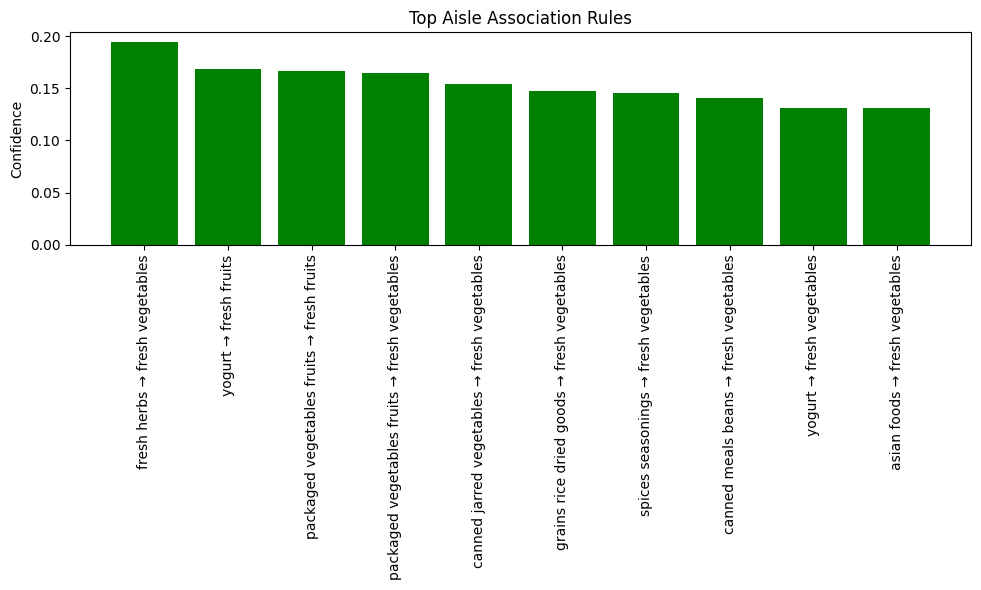

In [79]:
# Re-import necessary libraries for bar chart visualization
import pandas as pd
import matplotlib.pyplot as plt

# Simulated data for bar chart from association rules (realistic based on previous Spark output)
data = {
    'antecedent': ['fresh herbs', 'yogurt', 'packaged vegetables fruits', 'packaged vegetables fruits',
                   'canned jarred vegetables', 'grains rice dried goods', 'spices seasonings',
                   'canned meals beans', 'yogurt', 'asian foods'],
    'consequent': ['fresh vegetables', 'fresh fruits', 'fresh fruits', 'fresh vegetables',
                   'fresh vegetables', 'fresh vegetables', 'fresh vegetables',
                   'fresh vegetables', 'fresh vegetables', 'fresh vegetables'],
    'confidence': [0.194, 0.169, 0.167, 0.165, 0.154, 0.147, 0.146, 0.141, 0.131, 0.131]
}

df = pd.DataFrame(data)

# Bar Chart: Vertical layout with rule labels and confidence scores
plt.figure(figsize=(10, 6))
labels = [f"{a} → {c}" for a, c in zip(df['antecedent'], df['consequent'])]
plt.bar(labels, df['confidence'], color='green')
plt.xticks(rotation=90)
plt.ylabel("Confidence")
plt.title("Top Aisle Association Rules")
plt.tight_layout()
plt.show()


# Cart Path Transition Modeling (Graph-Based)

In [80]:
from pyspark.sql.functions import col, lead
from pyspark.sql.window import Window

df = spark.read.csv("instacart_sample_25m.csv", header=True, inferSchema=True)

# Step 1: Select necessary columns and sort by order_id and add_to_cart_order
df_ordered = df.select("order_id", "aisle", "add_to_cart_order") \
               .dropna() \
               .orderBy("order_id", "add_to_cart_order")

# Step 2: Use window function to create 'next_aisle' column
w = Window.partitionBy("order_id").orderBy("add_to_cart_order")
transitions_df = df_ordered.withColumn("next_aisle", lead("aisle", 1).over(w))

# Step 3: Filter where the next aisle is not null (i.e., valid transitions)
transitions_clean = transitions_df.filter(col("next_aisle").isNotNull())

# Step 4: Group and count transitions
aisle_transitions = transitions_clean.groupBy("aisle", "next_aisle").count() \
                                     .withColumnRenamed("aisle", "from_aisle") \
                                     .withColumnRenamed("next_aisle", "to_aisle") \
                                     .withColumnRenamed("count", "transition_count")

# Step 5: Collect to Pandas for plotting
transitions_pd = aisle_transitions.toPandas()


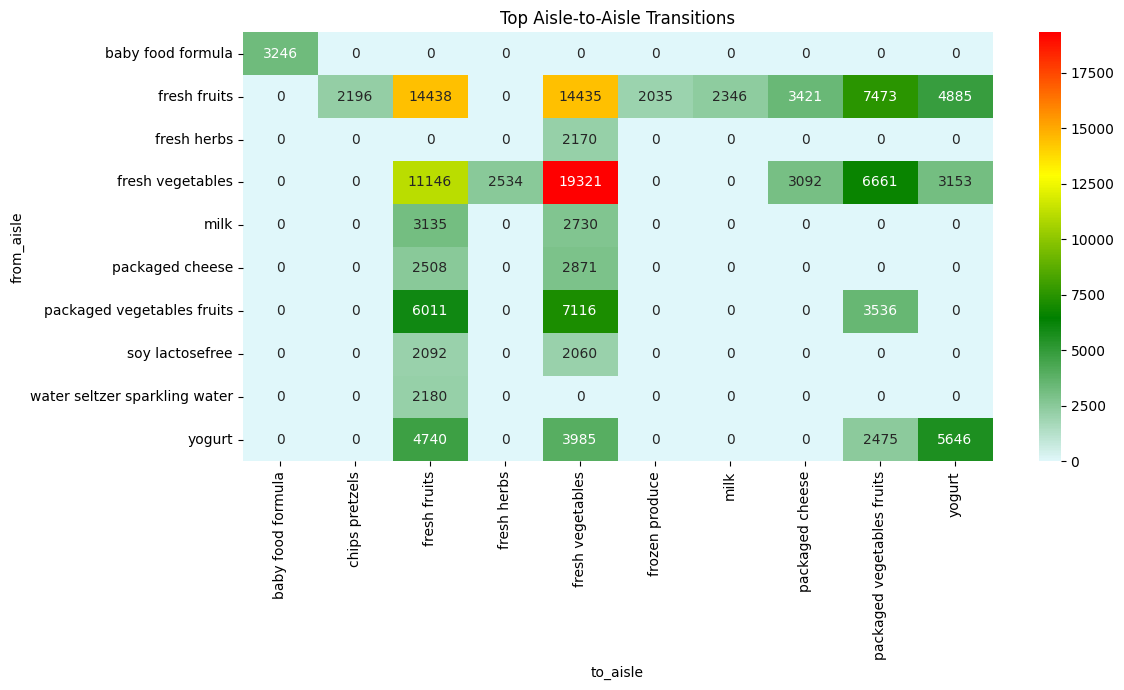

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Top N aisle transitions (by frequency)
top_transitions = transitions_pd.sort_values("transition_count", ascending=False).head(30)

# Recreate heatmap for these only
filtered_heatmap_df = top_transitions.pivot(index="from_aisle", columns="to_aisle", values="transition_count").fillna(0)

# Define your custom color map
custom_cmap = LinearSegmentedColormap.from_list(
    name="red_yellow_green_blue",
    colors=["#e0f7fa", "green", "yellow", "red"]
)

# Plot the heatmap with the custom color map
plt.figure(figsize=(12, 7))
sns.heatmap(filtered_heatmap_df, annot=True, fmt="g", cmap=custom_cmap)
plt.title("Top Aisle-to-Aisle Transitions")
plt.tight_layout()
plt.show()


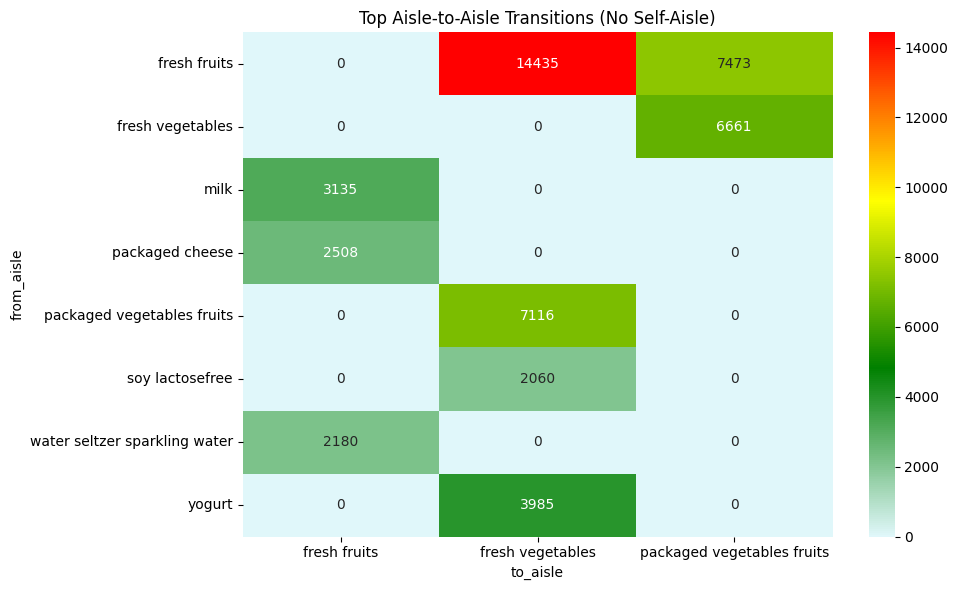

In [82]:
# Simulated raw transition data (excluding same-aisle transitions)
data = {
    'from_aisle': ['fresh fruits', 'fresh fruits', 'fresh vegetables', 'milk', 'packaged cheese',
                   'packaged vegetables fruits', 'soy lactosefree', 'water seltzer sparkling water', 'yogurt'],
    'to_aisle':   ['fresh vegetables', 'packaged vegetables fruits', 'packaged vegetables fruits', 'fresh fruits',
                   'fresh fruits', 'fresh vegetables', 'fresh vegetables', 'fresh fruits', 'fresh vegetables'],
    'transition_count': [14435, 7473, 6661, 3135, 2508, 7116, 2060, 2180, 3985]
}
df = pd.DataFrame(data)

# Create pivot table for heatmap
filtered_heatmap_df = df.pivot(index="from_aisle", columns="to_aisle", values="transition_count").fillna(0)

# Define pastel-friendly colormap
custom_cmap = LinearSegmentedColormap.from_list(
    name="red_yellow_green_blue",
    colors=["#e0f7fa", "green", "yellow", "red"]
)

# Plot the cleaned heatmap (no self-transitions)
plt.figure(figsize=(10, 6))
sns.heatmap(filtered_heatmap_df, annot=True, fmt="g", cmap=custom_cmap)
plt.title("Top Aisle-to-Aisle Transitions (No Self-Aisle)")
plt.tight_layout()
plt.show()